# Analysis notebook

This is an analysis notebook. It is mostly used for visualizing waveforms, targets and predictions in an easy fashion.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from benchmark import models
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import numpy as np
import re
import logging
import pandas as pd

In [17]:
data = sbd.STEAD(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.ETHZ(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.GEOFON(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.InstanceCountsCombined(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.NEIC(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.LenDB(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")
# data = sbd.SCEDC(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")

if "split" not in data.metadata.columns:
    logging.warning("No split defined, adding auxiliary split.")
    split = np.array(["train"] * len(data))
    split[int(0.6 * len(data)) : int(0.7 * len(data))] = "dev"
    split[int(0.7 * len(data)) :] = "test"

    data._metadata["split"] = split

dev_data = data.dev()

<ipython-input-17-19e154c85058>:1: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  data = sbd.STEAD(sampling_rate=100, component_order="ZNE", dimension_order="NCW", cache="trace")


## PhaseNet

In [62]:
model = models.PhaseNetLit.load_from_checkpoint("weights/stead_phasenet_stead_phasenet/2_2/checkpoints/epoch=91-step=96691.ckpt")
# model = models.PhaseNetLit.load_from_checkpoint("weights/ethz_phasenet_ethz_phasenet/0_0/checkpoints/epoch=97-step=8721.ckpt")
# model = models.PhaseNetLit.load_from_checkpoint("weights/geofon_phasenet_geofon_phasenet/0_0/checkpoints/epoch=80-step=12797.ckpt", sigma=50)
# model = models.PhaseNetLit(sigma=50, sample_boundaries=(-1000, None))

In [63]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_augmentations())

Detection probability: 0.45669180154800415
P or S: 0.9109008312225342


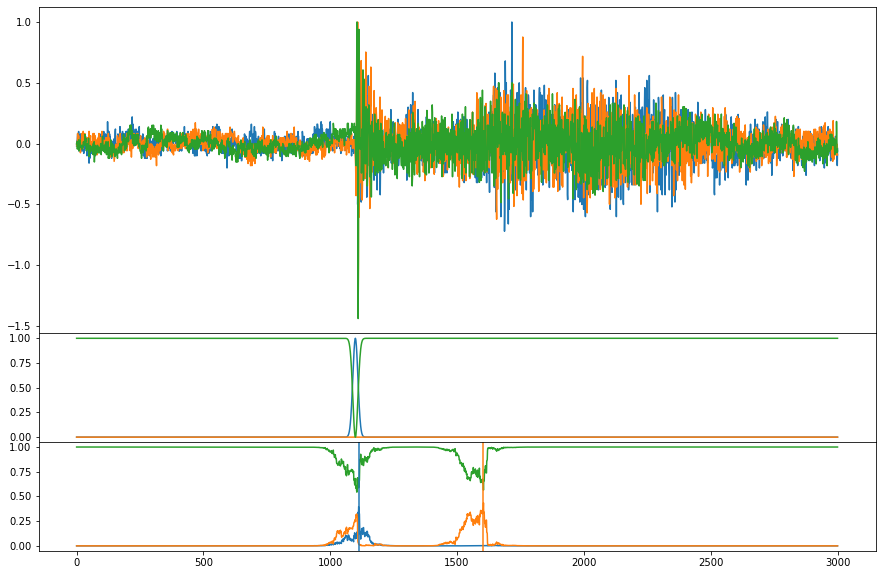

In [68]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    pred = model(torch.tensor(x.reshape(1, 3, 3001)))
    pred = pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(y.T)
axs[2].plot(pred.T)

batch = {key: torch.tensor(val).unsqueeze(0) for key, val in sample.items()}
batch["window_borders"] = torch.tensor([[0, 3000]])

score_detection, score_p_or_s, p_sample, s_sample = model.predict_step(batch)
axs[2].axvline(p_sample[0], color="C0")
axs[2].axvline(s_sample[0], color="C1")

print("Detection probability:", score_detection[0].item())
print("P or S:", score_p_or_s[0].item())

In [50]:
targets = pd.read_csv("targets/ethz/task23.csv")
targets = targets[targets["trace_split"] == "dev"]

steered_generator = sbg.SteeredGenerator(dev_data, targets)
steered_generator.add_augmentations(model.get_eval_augmentations())

Detection probability: 0.9476169943809509
P or S: 1.9306273460388184


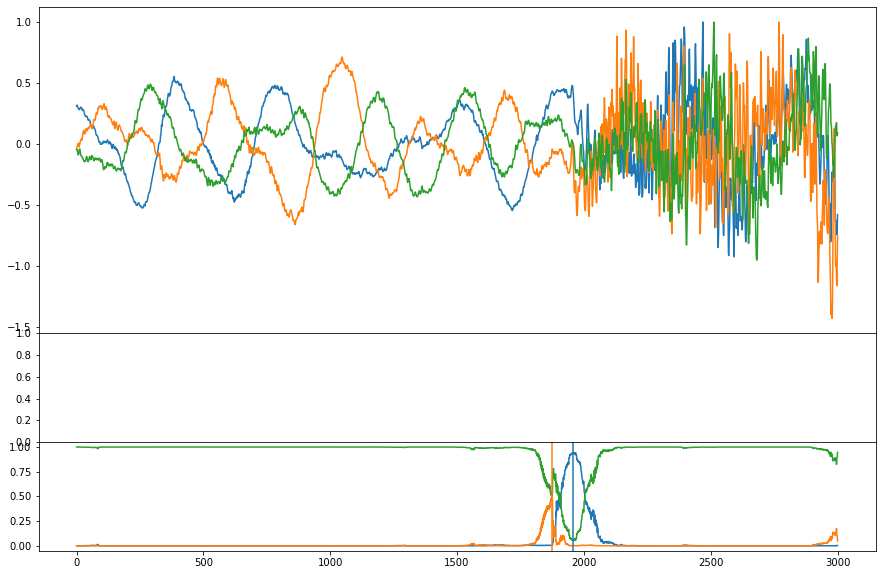

In [58]:
idx = 0
sample = steered_generator[idx]

x = sample["X"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    pred = model(torch.tensor(x.reshape(1, 3, 3001)))
    pred = pred.cpu().numpy()[0]

axs[0].plot(x.T)
# axs[1].plot(y.T)
axs[2].plot(pred.T)

batch = {key: torch.tensor(val).unsqueeze(0) for key, val in sample.items()}
start_sample = sample["window_borders"][0].item()

score_detection, score_p_or_s, p_sample, s_sample = model.predict_step(batch)
axs[2].axvline(start_sample + p_sample[0], color="C0")
axs[2].axvline(start_sample + s_sample[0], color="C1")

print("Detection probability:", score_detection[0].item())
print("P or S:", score_p_or_s[0].item())

In [59]:
steered_generator.metadata.iloc[idx]["start_sample"] + s_sample[0].item()

5931

In [60]:
steered_generator.metadata.iloc[idx]

trace_name          bucket8$0,:3,:27701
trace_idx                         10485
trace_split                         dev
sampling_rate                       100
start_sample                       5058
end_sample                         6058
phase_label                           P
full_phase_label                     Pg
phase_onset                      6000.0
Name: 16119, dtype: object

## GPD

In [8]:
# model = models.GPDLit(highpass=2)
model = models.GPDLit.load_from_checkpoint("weights/stead_gpd_stead_gpd/1_1/checkpoints/epoch=99-step=105099.ckpt")
# model = models.GPDLit.load_from_checkpoint("weights/geofon_gpd_geofon_gpd/1_1/checkpoints/epoch=95-step=15167.ckpt")
# model = models.GPDLit.load_from_checkpoint("weights/ethz_gpd_ethz_gpd/0_0/checkpoints/epoch=89-step=2069.ckpt")
# model = models.GPDLit.load_from_checkpoint("weights/instance_gpd_instance_gpd/0_0/checkpoints/epoch=88-step=67372.ckpt")
model.eval();

In [8]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_augmentations())

[1]
[  4.59949297e-05   3.48241657e-01   6.51712358e-01]


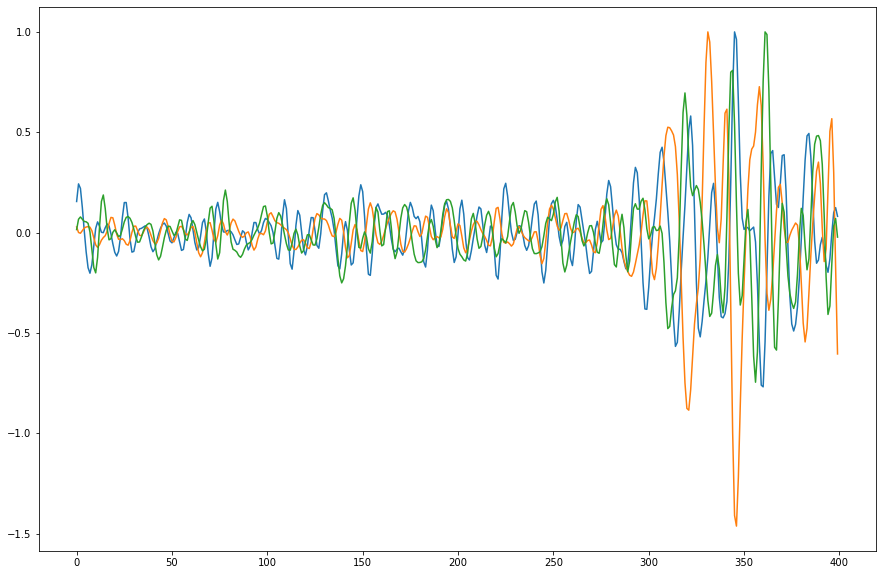

In [12]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"]

fig = plt.figure(figsize=(15, 10))
ax = fig.subplots(1, 1)

with torch.no_grad():
    pred = model(torch.tensor(x.reshape(1, 3, 400)))
    pred = pred.cpu().numpy()[0]

ax.plot(x.T)
print(y)
print(pred)

In [9]:
targets = pd.read_csv("targets/stead/task23.csv")
targets = targets[targets["trace_split"] == "dev"]

steered_generator = sbg.SteeredGenerator(dev_data, targets)
steered_generator.add_augmentations(model.get_eval_augmentations())

Detection probability: 1.0
P or S: 116.0878677368164


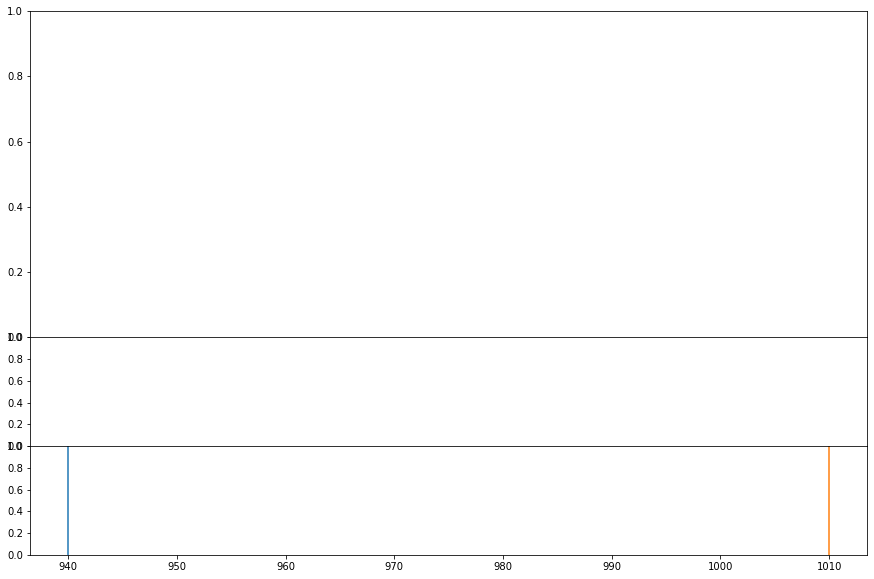

In [13]:
idx = 100
sample = steered_generator[idx]

x = sample["X"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

# axs[0].plot(x.T)
# axs[1].plot(y.T)
# axs[2].plot(pred.T)

batch = {key: torch.tensor(val).unsqueeze(0) for key, val in sample.items()}
start_sample = sample["window_borders"][0].item()

score_detection, score_p_or_s, p_sample, s_sample = model.predict_step(batch)
axs[2].axvline(start_sample + p_sample[0], color="C0")
axs[2].axvline(start_sample + s_sample[0], color="C1")

print("Detection probability:", score_detection[0].item())
print("P or S:", score_p_or_s[0].item())

In [14]:
steered_generator.metadata.iloc[idx]

trace_name          bucket237$578,:3,:6000
trace_idx                           236815
trace_split                            dev
sampling_rate                          100
start_sample                            13
end_sample                            1013
phase_label                              P
full_phase_label                         p
phase_onset                          918.0
Name: 2014, dtype: object

In [94]:
# torch.save(model.model.state_dict(), "/vol/home-vol3/wbi/muenchmj/instance.pt")

## EQTransformer

In [69]:
# model = models.EQTransformerLit(sigma=50, rotate_array=True)
model = models.EQTransformerLit.load_from_checkpoint("weights/stead_eqtransformer_stead_eqtransformer/0_0/checkpoints/epoch=75-step=79875.ckpt")
# model = models.EQTransformerLit.load_from_checkpoint("weights/ethz_eqtransformer_ethz_eqtransformer/0_0/checkpoints/epoch=89-step=2069.ckpt")
# model = models.EQTransformerLit.load_from_checkpoint("weights/neic_eqtransformer_neic_eqtransformer/1_1/checkpoints/epoch=92-step=88721.ckpt")
model.eval();

In [70]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_val_augmentations())
# dev_generator.add_augmentations(model.get_train_augmentations())

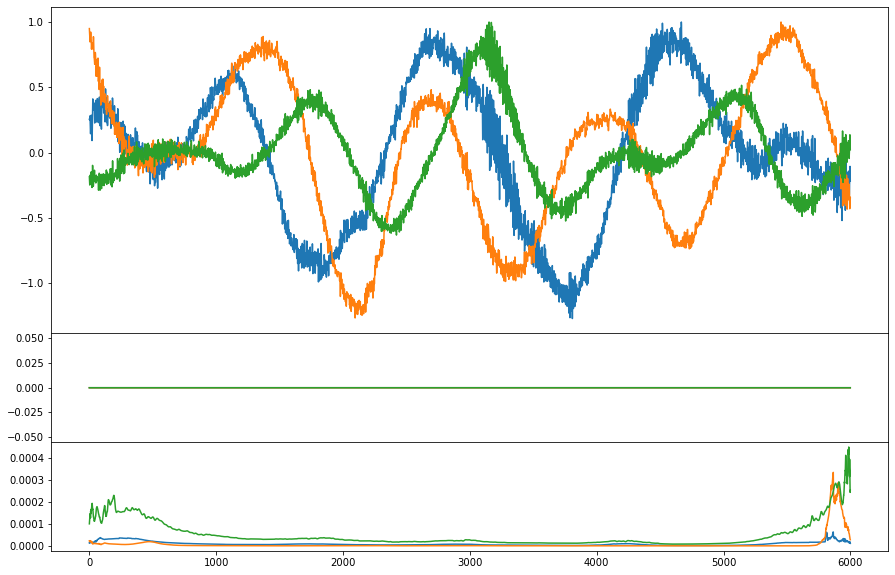

In [88]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"][:2]
detection = sample["detections"][0]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    det_pred, p_pred, s_pred = model(torch.tensor(x.reshape(1, 3, 6000)))
    det_pred = det_pred.cpu().numpy()[0]
    p_pred = p_pred.cpu().numpy()[0]
    s_pred = s_pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(y.T)
axs[1].plot(detection)
axs[2].plot(p_pred)
axs[2].plot(s_pred)
axs[2].plot(det_pred)

In [75]:
# torch.save(model.model.state_dict(), "/vol/home-vol3/wbi/muenchmj/stead.pt")

## CRED

In [18]:
# model = models.CREDLit()
model = models.CREDLit.load_from_checkpoint("weights/stead_cred_stead_cred/0_0/checkpoints/epoch=85-step=90385.ckpt")
model.eval();

In [19]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_val_augmentations())

(-0.05, 1.05)

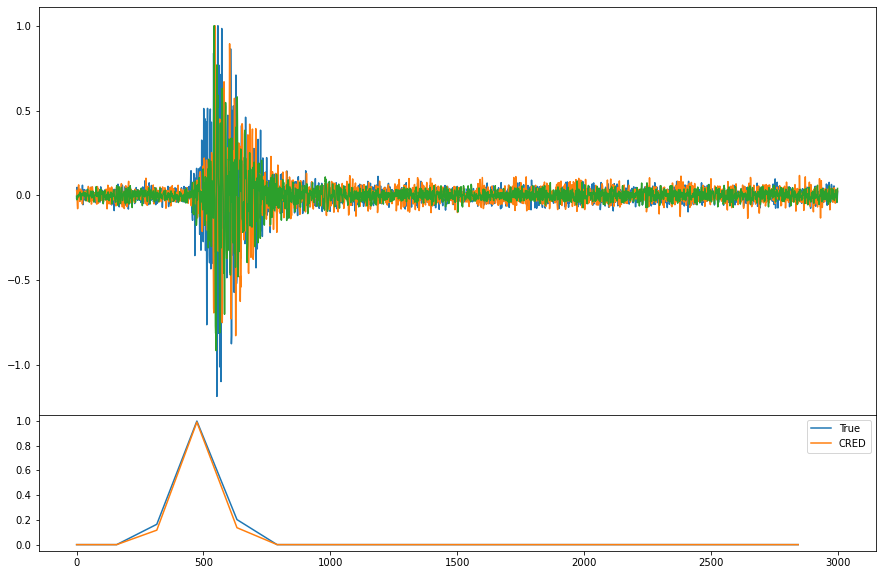

In [20]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"][0]
spec = sample["spec"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1)})

with torch.no_grad():
    pred = model(torch.tensor(spec.reshape(1, 3, 76, 41)))
    pred = pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(158 * np.arange(19), y, label="True")
axs[1].plot(158 * np.arange(19), pred, label="CRED")
axs[1].legend()
axs[1].set_ylim(-0.05, 1.05)

## BasicPhaseAE

In [23]:
model = models.BasicPhaseAELit()
model = models.BasicPhaseAELit.load_from_checkpoint("weights/stead_basicphaseae_stead_basicphaseae/0_0/checkpoints/epoch=12-step=13662.ckpt")

In [24]:
dev_generator = sbg.GenericGenerator(dev_data)
dev_generator.add_augmentations(model.get_val_augmentations())

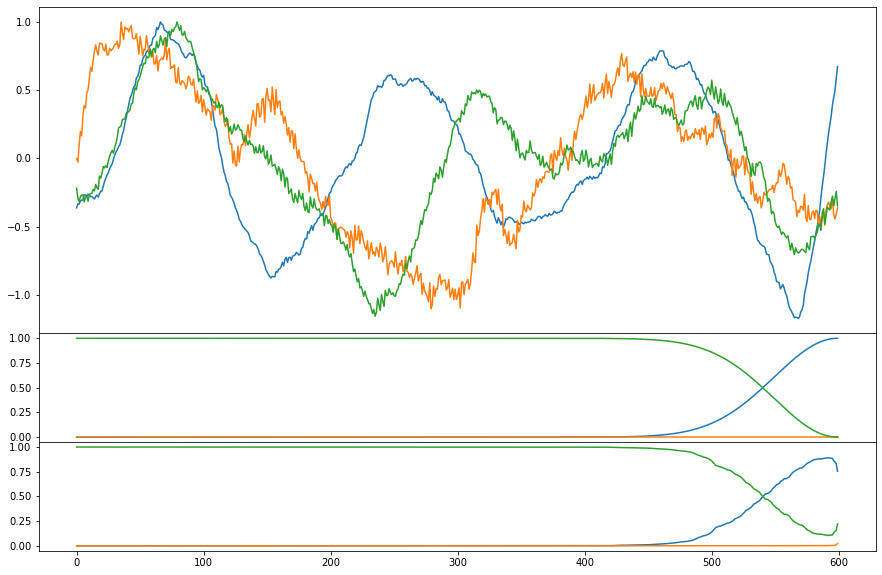

In [25]:
idx = np.random.randint(len(dev_generator))
sample = dev_generator[idx]

x = sample["X"]
y = sample["y"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    pred = model(torch.tensor(x).unsqueeze(0))
    pred = pred.cpu().numpy()[0]

axs[0].plot(x.T)
axs[1].plot(y.T)
axs[2].plot(pred.T)

In [28]:
targets = pd.read_csv("targets/stead/task23.csv")
targets = targets[targets["trace_split"] == "dev"]

steered_generator = sbg.SteeredGenerator(dev_data, targets)
steered_generator.add_augmentations(model.get_eval_augmentations())

Detection probability: 0.96122807264328
P or S: 1.1061087846755981


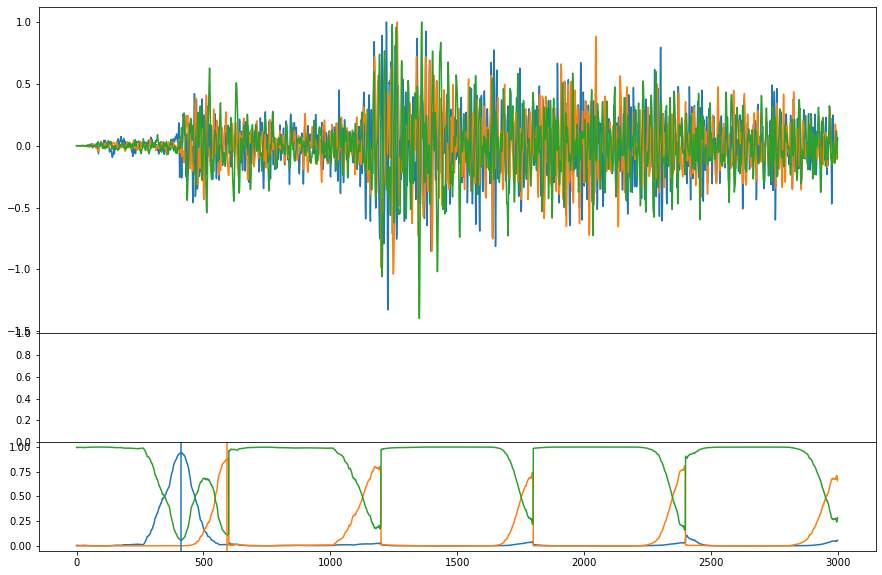

In [38]:
idx = np.random.randint(len(steered_generator))
sample = steered_generator[idx]

x = sample["X"]

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios': (3, 1, 1)})

with torch.no_grad():
    x = torch.tensor(x).unsqueeze(0)
    x = x.reshape(x.shape[:-1] + (5, 600))  # Split into 5 windows of length 600
    x = x.permute(0, 2, 1, 3)  # --> (batch, windows, channels, samples)
    shape_save = x.shape
    x = x.reshape(-1, 3, 600)  # --> (batch * windows, channels, samples)
    pred = model(x)
    pred = pred.reshape(shape_save[:2] + (3, 600))  # --> (batch, window, channels, samples)
    pred = torch.cat([pred[:, i] for i in range(5)], dim=-1)
    pred = pred.cpu().numpy()[0]

axs[0].plot(sample["X"].T)
# axs[1].plot(y.T)
axs[2].plot(pred.T)

batch = {key: torch.tensor(val).unsqueeze(0) for key, val in sample.items()}
start_sample = sample["window_borders"][0].item()

score_detection, score_p_or_s, p_sample, s_sample = model.predict_step(batch)
axs[2].axvline(start_sample + p_sample[0], color="C0")
axs[2].axvline(start_sample + s_sample[0], color="C1")

print("Detection probability:", score_detection[0].item())
print("P or S:", score_p_or_s[0].item())

## Visualize evaluation targets

In [213]:
task1 = pd.read_csv("targets/lendb/task1.csv")
task1

,trace_name,trace_idx,trace_split,sampling_rate,start_sample,end_sample,trace_type
0,"bucket0$1,:3,:540",0,NaN,100,0,2700,earthquake
1,"bucket0$11,:3,:540",1,NaN,100,0,2700,earthquake
2,"bucket0$34,:3,:540",2,NaN,100,0,2700,earthquake
3,"bucket0$50,:3,:540",3,NaN,100,0,2700,earthquake
4,"bucket0$69,:3,:540",4,NaN,100,0,2700,earthquake
...,...,...,...,...,...,...,...
62595,"bucket1215$714,:3,:540",62595,NaN,100,0,2700,noise
62596,"bucket1215$717,:3,:540",62596,NaN,100,0,2700,noise
62597,"bucket1215$720,:3,:540",62597,NaN,100,0,2700,noise
62598,"bucket1215$723,:3,:540",62598,NaN,100,0,2700,noise


In [214]:
print(np.min(task1["end_sample"] - task1["start_sample"]))
print(np.max(task1["end_sample"] - task1["start_sample"]))

2700
2700


In [215]:
np.where(task1["end_sample"] - task1["start_sample"] > 3000)

(array([], dtype=int64),)

earthquake


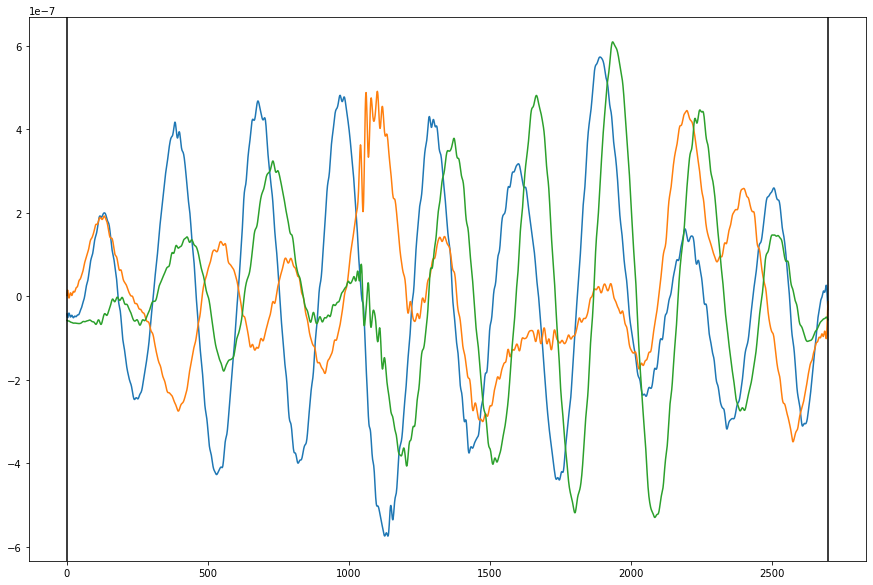

In [226]:
base_idx = np.random.randint(len(task1))
# base_idx = 47265

row = task1.iloc[base_idx]

idx = np.where(data.metadata["trace_name"] == row["trace_name"])[0][0]

waveforms, metadata = data.get_sample(idx)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

ax.plot(waveforms.T)
ax.axvline(row["start_sample"], color="k")
ax.axvline(row["end_sample"], color="k")
print(row["trace_type"])

In [227]:
task23 = pd.read_csv("targets/lendb/task23.csv")
task23

,trace_name,trace_idx,trace_split,sampling_rate,start_sample,end_sample,phase_label,full_phase_label,phase_onset
0,"bucket0$1,:3,:540",0,NaN,100,102,1102,P,p,400.0
1,"bucket0$11,:3,:540",1,NaN,100,348,1348,P,p,400.0
2,"bucket0$34,:3,:540",2,NaN,100,270,1270,P,p,400.0
3,"bucket0$50,:3,:540",3,NaN,100,106,1106,P,p,400.0
4,"bucket0$69,:3,:540",4,NaN,100,71,1071,P,p,400.0
...,...,...,...,...,...,...,...,...,...
31548,"bucket614$313,:3,:540",31548,NaN,100,299,1299,P,p,400.0
31549,"bucket614$335,:3,:540",31549,NaN,100,44,1044,P,p,400.0
31550,"bucket614$336,:3,:540",31550,NaN,100,252,1252,P,p,400.0
31551,"bucket614$352,:3,:540",31551,NaN,100,50,1050,P,p,400.0


In [228]:
print(np.min(task23["end_sample"] - task23["start_sample"]))
print(np.max(task23["end_sample"] - task23["start_sample"]))

1000
1000


In [229]:
np.where(task23["end_sample"] - task23["start_sample"] > 1000)[0]

array([], dtype=int64)

P p


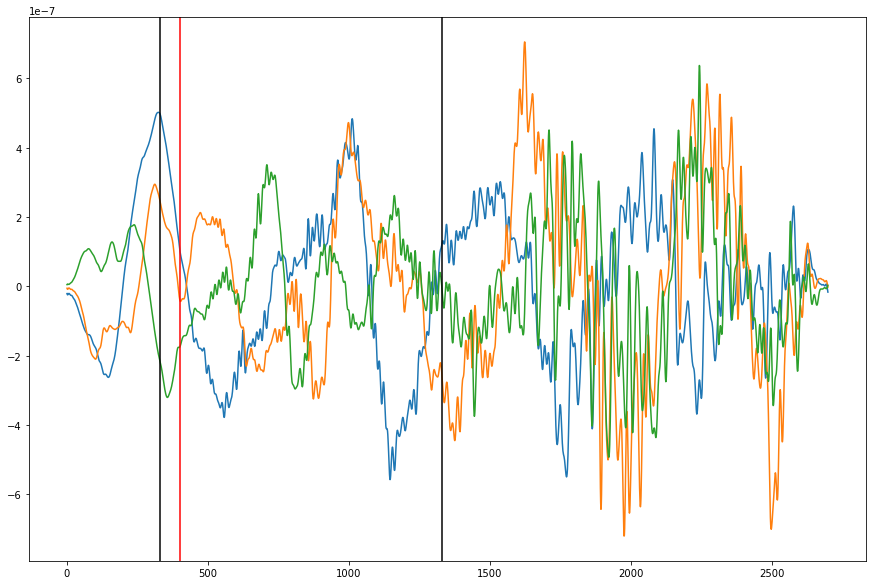

In [242]:
base_idx = np.random.randint(len(task23))
# base_idx = 84

row = task23.iloc[base_idx]

idx = np.where(data.metadata["trace_name"] == row["trace_name"])[0][0]

waveforms, metadata = data.get_sample(idx)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

ax.plot(waveforms.T)
ax.axvline(row["start_sample"], color="k")
ax.axvline(row["end_sample"], color="k")
ax.axvline(row["phase_onset"], color="r")

print(row["phase_label"], row["full_phase_label"])

In [231]:
task23["full_phase_label"].value_counts()

p    31553
Name: full_phase_label, dtype: int64